# Redes neurais
- amoxicillin net production (synthesis −hydrolysis) ⇒ νAN =νs −νh2;
- p-hydroxyphenylglycine production (hydrolysis of ester + hydrolysis of amoxicillin) ⇒ νAOH =νh1 +νh2.

- Extra: treinar para simular o modelo todo


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib_inline.backend_inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Modelo inicial
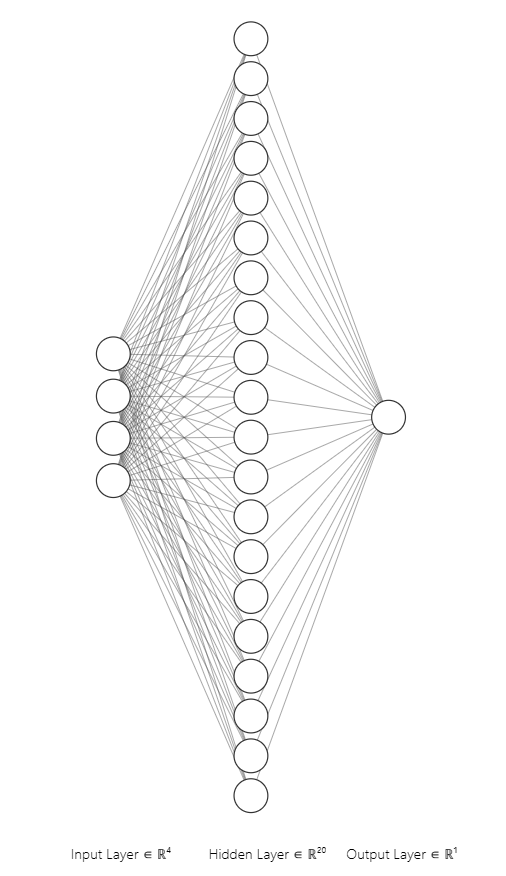

In [20]:
class genericHybridANN(nn.Module):
    def __init__(self):
        '''Populate with the layers of the model'''
        super().__init__()

        # define layers
        self.input = nn.Linear(4,20)
        self.output = nn.Linear(20,1)

    def forward(self,x):
        '''Operations that are taking place in the layers'''

        # input
        x = F.relu(self.input(x))       
        # output
        x = self.output(x)
        
        return x

In [21]:
def train(model, lossfun, optimizer, inputs, targets, epochs=100):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossfun(outputs, targets)
        loss.backward()
        optimizer.step()
        losses[epoch] = loss.item()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs} - Loss: {loss.item()}')
    return losses

mudanças necessárias:
- "fez-se uma adaptação na rede, trocando a função sigmoidal por 
função tangente hiperbólica...  Como a maior desvantagem deste procedimento de treinamento é que, 
se a superfície erro tiver um mínimo local, o gradiente descendente pode não ser 
capaz de encontrar o mínimo global [Rumelhart et al. (1986)], acredita-se que a 
rede tenha ficado presa em um mínimo local."
- "Manteve-se a função de transferência 
sigmoidal, mas neste caso normalizam-se os dados de entrada de tal maneira que 
velocidades negativas conseguem ser representadas. Também neste caso houve 
problemas durante o treinamento da rede, mas eles foram resolvidos deixando a 
taxa de aprendizado fixa em 1"

# Tratamento de dados

Glossário

AMOX - Produto - AN

POHPGME - Éster - AB

6-APA - Núcleo - NH 

POHPG - Subproduto - AOH

Vhide - Velocidade de hidrólise de Ester

Vhamox - Velocidade de hidrólise de Amoxilina

Vs - Velocidade de síntese de Amoxilina

### Importando dados:

- Hidrólise de amoxicilina
- Hidrólise de ester
- Síntese de amoxicilina

In [22]:
hid_amox = pd.read_csv('DadosRN/Treinamento/Vel_hid_amox.csv',sep=';')
hid_ester = pd.read_csv('DadosRN/Treinamento/Vel_hid_ester.csv',sep=';')
s_amox = pd.read_csv('DadosRN/Treinamento/Vel_sintese_amox.csv',sep=';')

ha_train = torch.Tensor(hid_amox.iloc[:,:4].to_numpy())
he_train = torch.Tensor(hid_ester.iloc[:,:4].to_numpy())
s_train = torch.Tensor(s_amox.iloc[:,:4].to_numpy())

ha_target = torch.Tensor(hid_amox.iloc[:,4].to_numpy())
he_target = torch.Tensor(hid_ester.iloc[:,4].to_numpy())
s_target = torch.Tensor(s_amox.iloc[:,4].to_numpy())

train_data = pd.concat([hid_amox,hid_ester,s_amox],axis=0)
train_data

,AMOX,NH,AB,AOH,Vhamox,Vhide,Vs
0,15,0,0,0,0.171723,NaN,NaN
1,25,0,0,0,0.208859,NaN,NaN
2,40,0,0,0,0.261208,NaN,NaN
3,5,0,0,15,0.051489,NaN,NaN
4,15,0,0,15,0.103191,NaN,NaN
5,25,0,0,15,0.167340,NaN,NaN
6,40,0,0,15,0.199894,NaN,NaN
7,5,0,0,5,0.048602,NaN,NaN
8,15,0,0,5,0.113978,NaN,NaN
9,25,0,0,5,0.166452,NaN,NaN


In [23]:
def train(model, lossfun, optimizer, inputs, targets, epochs=100):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossfun(outputs, targets)
        loss.backward()
        optimizer.step()
        losses[epoch] = loss.item()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs} - Loss: {loss.item()}')
    return losses

In [24]:
def run_training(model,x_train,y_train,epochs=200,lr=.05):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
    model.train()
    losses = train(model, nn.MSELoss(), optimizer, x_train, y_train,epochs=epochs)
    return losses, model

In [25]:
ha_model = genericHybridANN()
he_model = genericHybridANN()
s_model =  genericHybridANN()

In [26]:
ha_losses, ha_model = run_training(ha_model,ha_train,ha_target,epochs=500,lr=0.01)
he_losses, he_model = run_training(he_model,he_train,he_target,epochs=500,lr=0.01)
s_losses , s_model  = run_training(s_model,s_train,s_target,epochs=500,lr=0.01)

c:\Users\artur\Desktop\lneoc\pibic_lneoc\deep_learning\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0/500 - Loss: 21.495119094848633
Epoch 10/500 - Loss: 1.8941580057144165
Epoch 20/500 - Loss: 0.8135145306587219
Epoch 30/500 - Loss: 0.21101664006710052
Epoch 40/500 - Loss: 0.07749957591295242
Epoch 50/500 - Loss: 0.01827940158545971
Epoch 60/500 - Loss: 0.008943365886807442
Epoch 70/500 - Loss: 0.007199905347079039
Epoch 80/500 - Loss: 0.005185921676456928
Epoch 90/500 - Loss: 0.005035598296672106
Epoch 100/500 - Loss: 0.0047754752449691296
Epoch 110/500 - Loss: 0.004643963184207678
Epoch 120/500 - Loss: 0.0045856391079723835
Epoch 130/500 - Loss: 0.004533096682280302
Epoch 140/500 - Loss: 0.004492202308028936
Epoch 150/500 - Loss: 0.004463504999876022
Epoch 160/500 - Loss: 0.004439756739884615
Epoch 170/500 - Loss: 0.004420039243996143
Epoch 180/500 - Loss: 0.004403570666909218
Epoch 190/500 - Loss: 0.004389670677483082
Epoch 200/500 - Loss: 0.004377936944365501
Epoch 210/500 - Loss: 0.004368062596768141
Epoch 220/500 - Loss: 0.004359744023531675
Epoch 230/500 - Loss: 0.00435

c:\Users\artur\Desktop\lneoc\pibic_lneoc\deep_learning\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 180/500 - Loss: 0.004260333254933357
Epoch 190/500 - Loss: 0.00425265496596694
Epoch 200/500 - Loss: 0.004246666096150875
Epoch 210/500 - Loss: 0.004241800867021084
Epoch 220/500 - Loss: 0.0042376890778541565
Epoch 230/500 - Loss: 0.004234070423990488
Epoch 240/500 - Loss: 0.004230800084769726
Epoch 250/500 - Loss: 0.004227759316563606
Epoch 260/500 - Loss: 0.004224903881549835
Epoch 270/500 - Loss: 0.004222183953970671
Epoch 280/500 - Loss: 0.004219584167003632
Epoch 290/500 - Loss: 0.004217089153826237
Epoch 300/500 - Loss: 0.0042146858759224415
Epoch 310/500 - Loss: 0.004212370608001947
Epoch 320/500 - Loss: 0.004210140090435743
Epoch 330/500 - Loss: 0.004207982681691647
Epoch 340/500 - Loss: 0.004205908626317978
Epoch 350/500 - Loss: 0.004203892778605223
Epoch 360/500 - Loss: 0.004201960284262896
Epoch 370/500 - Loss: 0.004200081340968609
Epoch 380/500 - Loss: 0.004198272712528706
Epoch 390/500 - Loss: 0.0041965218260884285
Epoch 400/500 - Loss: 0.0041948300786316395
Epoch 41

c:\Users\artur\Desktop\lneoc\pibic_lneoc\deep_learning\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/500 - Loss: 0.06898505240678787
Epoch 90/500 - Loss: 0.05426648631691933
Epoch 100/500 - Loss: 0.04831349104642868
Epoch 110/500 - Loss: 0.04162583127617836
Epoch 120/500 - Loss: 0.03399163484573364
Epoch 130/500 - Loss: 0.027504922822117805
Epoch 140/500 - Loss: 0.022383831441402435
Epoch 150/500 - Loss: 0.01852693408727646
Epoch 160/500 - Loss: 0.015562540851533413
Epoch 170/500 - Loss: 0.013289119116961956
Epoch 180/500 - Loss: 0.01154350582510233
Epoch 190/500 - Loss: 0.010568947531282902
Epoch 200/500 - Loss: 0.009764398448169231
Epoch 210/500 - Loss: 0.009081508032977581
Epoch 220/500 - Loss: 0.0085020512342453
Epoch 230/500 - Loss: 0.007969221100211143
Epoch 240/500 - Loss: 0.007471785880625248
Epoch 250/500 - Loss: 0.007004898972809315
Epoch 260/500 - Loss: 0.006566742900758982
Epoch 270/500 - Loss: 0.006156485993415117
Epoch 280/500 - Loss: 0.0057732523418962955
Epoch 290/500 - Loss: 0.005416079889982939
Epoch 300/500 - Loss: 0.00508399773389101
Epoch 310/500 - Loss: 

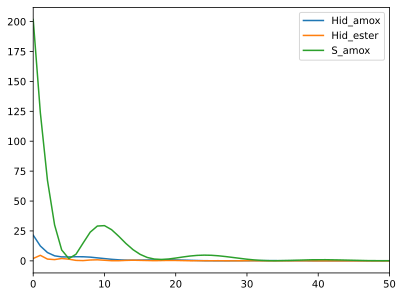

In [27]:
plt.plot(ha_losses,label='Hid_amox')
plt.plot(he_losses,label='Hid_ester')
plt.plot(s_losses,label='S_amox')
plt.xlim([0,50])
plt.legend()

## Validação

torch.Size([20, 4])
torch.Size([20])


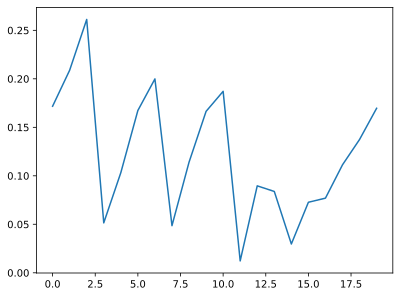

In [28]:
hid_amox_val = pd.read_csv('DadosRN/Validação/Vel_hid_amox.csv',sep=';')
hid_ester_val = pd.read_csv('DadosRN/Validação/Vel_hid_ester.csv',sep=';')
s_amox_val = pd.read_csv('DadosRN/Validação/Vel_sintese_amox.csv',sep=';')

ha_val= torch.Tensor(hid_amox.iloc[:,:4].to_numpy())
print(ha_val.shape)
he_val = torch.Tensor(hid_ester.iloc[:,:4].to_numpy())
s_val = torch.Tensor(s_amox.iloc[:,:4].to_numpy())

ha_val_target = torch.Tensor(hid_amox.iloc[:,4].to_numpy())
print(ha_val_target.shape)
he_val_target = torch.Tensor(hid_ester.iloc[:,4].to_numpy())
s_val_target = torch.Tensor(s_amox.iloc[:,4].to_numpy())
plt.plot(ha_val_target)

Text(0.5, 1.0, 'Validação Sintese Amox')

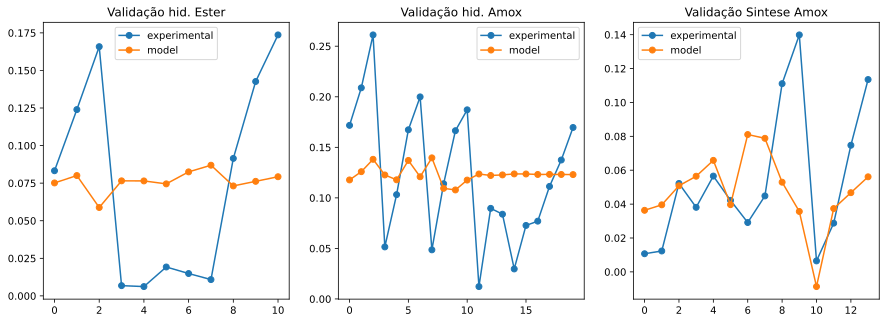

In [29]:
fig,ax = plt.subplots(1,3,figsize=[15,5])
ax[0].plot(he_val_target,'-o',label='experimental')
ax[0].plot(he_model(he_val).detach(),'-o',label='model')
ax[0].legend()
ax[0].set_title('Validação hid. Ester')

ax[1].plot(ha_val_target,'-o',label='experimental')
ax[1].plot(ha_model(ha_val).detach(),'-o',label='model')
ax[1].legend()
ax[1].set_title('Validação hid. Amox')

ax[2].plot(s_val_target,'-o',label='experimental')
ax[2].plot(s_model(s_val).detach(),'-o',label='model')
ax[2].legend()
ax[2].set_title('Validação Sintese Amox')